In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import identify_nominal_columns
from sklearn.model_selection import train_test_split
from geopy import distance
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import xgboost as xgb
from geopy import distance
from sklearn.model_selection import GridSearchCV


from utils import preprocess

In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1 Data Cleaning & Explorative Data Analysis (EDA)
    1.1 Dirty records
    1.2 Missing(NaN) value
    1.3 records against the correctness of string values(descripiton)
    1.4 Categorical Attributes tranformation:
    1.5 feature engineering (undone)
    1.6 noise detection (undone)

In [98]:
DATA_DIR = 'data/'
IMG_DIR = 'img/'
TRAIN_FILE = DATA_DIR + 'train.csv'
TEST_FILE = DATA_DIR + 'train.csv'
AUX_DATA_DIR = DATA_DIR + 'auxiliary-data/'

raw_data_train = pd.read_csv(TRAIN_FILE)
raw_data_train.head()

COMC = AUX_DATA_DIR + 'sg-commerical-centres.csv'
MRT = AUX_DATA_DIR + 'sg-mrt-stations.csv'
PSCHOOL = AUX_DATA_DIR + 'sg-primary-schools.csv'
SSCHOOL = AUX_DATA_DIR + 'sg-secondary-schools.csv'
MALL = AUX_DATA_DIR + 'sg-shopping-malls.csv'

mrt_station = pd.read_csv(MRT)
comc = pd.read_csv(COMC)
pschool = pd.read_csv(PSCHOOL)
sschool = pd.read_csv(SSCHOOL)
mall = pd.read_csv(MALL)

### 1.1 Handling missing value
* `tenure`: 1723 records. Delete the entire columns. (doubtful)
* `built_year`: 922 records. Fill in the year with the same property name and the mean building year of entire samples in case without transcation in the same property.
* `num_beds`: 80 records.
* `num_baths`: 434 records.
* `floor_level`: 16746 records.
* `available_unit_types`: 1441 records.
* `total_num_units`: 5652 records.
* `subzone` and `planning_area`: both 113 records.

In [99]:
## convert to all lowercase first.

df_lowercase = raw_data_train.copy()

## lowercase all categotical value
categorical_features=identify_nominal_columns(df_lowercase)
for feature in categorical_features:
    df_lowercase[feature] = df_lowercase[feature].str.lower()

df_lowercase.head()

,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,...,furnishing,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price
0,122881,hdb flat for sale in 866 yishun street 81,sembawang / yishun (d27),866 yishun street 81,hdb 4 rooms,NaN,1988.0,3.0,2.0,1115,...,unspecified,NaN,116.0,https://www.99.co/singapore/hdb/866-yishun-str...,1.414399,103.837196,0,yishun south,yishun,514500.0
1,259374,hdb flat for sale in 506b serangoon north aven...,hougang / punggol / sengkang (d19),hdb-serangoon estate,hdb,99-year leasehold,1992.0,4.0,2.0,1575,...,unspecified,"1, 2, 3, 4, 5, 6 br",NaN,https://www.99.co/singapore/hdb/hdbserangoon-e...,1.372597,103.875625,0,serangoon north,serangoon,995400.0
2,665422,4 bed condo for sale in meyerhouse,128 meyer road,meyerhouse,condo,freehold,2022.0,4.0,6.0,3070,...,partial,"studio, 3, 4, 5, 6 br",56.0,https://www.99.co/singapore/condos-apartments/...,1.298773,103.895798,0,mountbatten,marine parade,8485000.0
3,857699,3 bed condo for sale in leedon green,26 leedon heights,leedon green,condo,freehold,2023.0,3.0,2.0,958,...,partial,"studio, 1, 2, 3, 4 br",638.0,https://www.99.co/singapore/condos-apartments/...,1.312364,103.803271,0,farrer court,bukit timah,2626000.0
4,216061,2 bed condo for sale in one bernam,1 bernam street,one bernam,condo,99-year leasehold,2026.0,2.0,1.0,732,...,unspecified,"studio, 1, 2, 3, 4, 5 br",351.0,https://www.99.co/singapore/condos-apartments/...,1.273959,103.843635,0,anson,downtown core,1764000.0


## 1.1.1 num_beds & num_baths

In [227]:
df_with_nan = df_lowercase.copy()

# drop some columns directly
droplist = ['listing_id', 'title', 'elevation','floor_level', 'available_unit_types', 'total_num_units', 'property_details_url']

df_with_nan.drop(columns=droplist, inplace=True)
df_with_nan.head()

,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,lat,lng,subzone,planning_area,price
0,sembawang / yishun (d27),866 yishun street 81,hdb 4 rooms,NaN,1988.0,3.0,2.0,1115,unspecified,1.414399,103.837196,yishun south,yishun,514500.0
1,hougang / punggol / sengkang (d19),hdb-serangoon estate,hdb,99-year leasehold,1992.0,4.0,2.0,1575,unspecified,1.372597,103.875625,serangoon north,serangoon,995400.0
2,128 meyer road,meyerhouse,condo,freehold,2022.0,4.0,6.0,3070,partial,1.298773,103.895798,mountbatten,marine parade,8485000.0
3,26 leedon heights,leedon green,condo,freehold,2023.0,3.0,2.0,958,partial,1.312364,103.803271,farrer court,bukit timah,2626000.0
4,1 bernam street,one bernam,condo,99-year leasehold,2026.0,2.0,1.0,732,unspecified,1.273959,103.843635,anson,downtown core,1764000.0


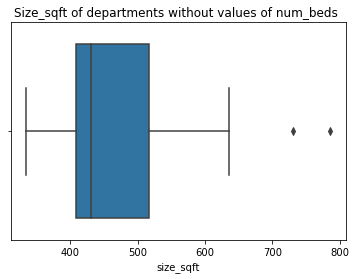

In [228]:
sns.boxplot(data=df_with_nan.loc[(df_with_nan.num_beds.isna()) & (df_with_nan.size_sqft <= 800)], x='size_sqft')
plt.title("Size_sqft of departments without values of num_beds ")
plt.savefig('barplot1.png')

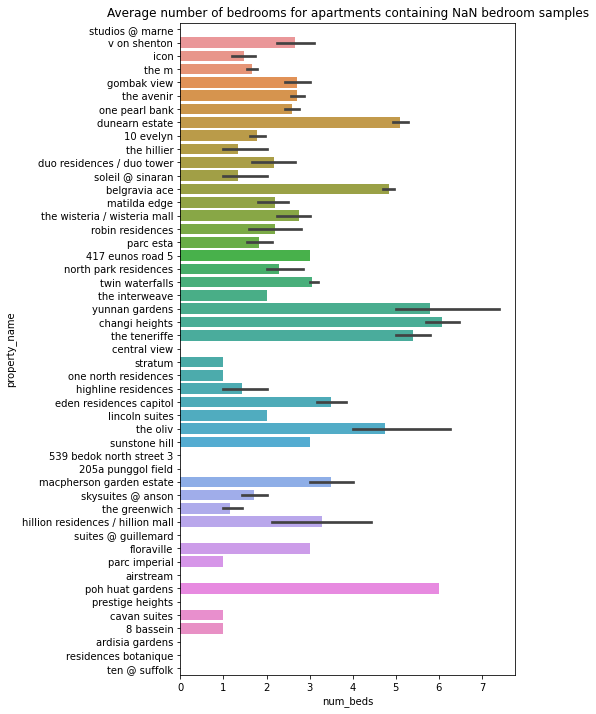

In [248]:
plt.figure(figsize=(6,12))
pn = df_with_nan['property_name'][df_with_nan.num_beds.isna()].unique()
check1 = df_with_nan.loc[np.in1d(df_with_nan['property_name'],pn)]
sns.barplot(data=check1, x='num_beds', y='property_name')
plt.title("Average number of bedrooms for apartments containing NaN bedroom samples")
plt.savefig("barplot2.png")

In [246]:
df_non_nan = df_with_nan.copy()
preprocess.process_num_beds_and_baths(df_non_nan)
df_non_nan['num_beds'].value_counts()

3.0     7942
2.0     4365
4.0     3571
1.0     1684
5.0     1628
6.0      768
7.0      148
0.0       62
8.0       41
10.0      29
9.0       16
Name: num_beds, dtype: int64

In [247]:
df_non_nan['num_baths'].value_counts()

2.0     9972
3.0     3150
1.0     3048
4.0     1754
5.0      937
6.0      854
7.0      383
8.0       96
9.0       35
10.0      25
Name: num_baths, dtype: int64

In [216]:
#sns.heatmap(raw_data_train[['poutcome', 'month']])
def heatmap_y(columns, dataset, figsize, show_fig = True, save_path=[]):
    '''
    show how the conbination of 2 categorical columns will show different probility for `yes` label. 
    '''
    tmp1 = dataset.copy()
    tmp1.reset_index(inplace=True)
    property_type = tmp1.loc[0,'property_type']
    
    tmp1['num'] = 1
    tmp1 = tmp1[columns].groupby(by=columns[:-1]).sum() / tmp1.shape[0]
    tmp1.reset_index(inplace=True)
    tmp1 = tmp1.pivot(columns[0], columns[1], columns[2])
    
    if show_fig: 
        plt.figure(figsize=figsize)
        ax = sns.heatmap(tmp1, cmap="YlGnBu")
        plt.title(f'Occurrence frequency between {columns[0]} and {columns[1]} for {property_type} ')
        if len(save_path) > 0:
            plt.savefig(save_path)
            
    return tmp1

num_baths,1.0,2.0,3.0,4.0,5.0,10.0
num_beds,,,,,,
1.0,0.011371,0.002211,NaN,NaN,NaN,0.000316
2.0,0.043588,0.152558,0.000474,NaN,NaN,NaN
3.0,0.011529,0.615919,0.019899,0.000632,NaN,NaN
4.0,0.000158,0.101706,0.027637,0.002053,NaN,NaN
5.0,NaN,0.003790,0.002211,0.000790,0.000158,NaN
6.0,NaN,0.001263,0.000790,0.000632,NaN,NaN
7.0,NaN,NaN,0.000316,NaN,NaN,NaN


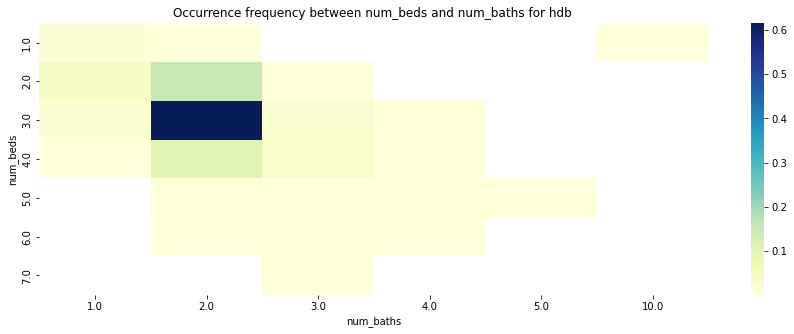

In [220]:
columns = ['num_beds','num_baths','num']
save_path = 'Heatmap1.png'
heatmap_y(columns, df_train.loc[df_train['property_type'] == 'hdb'], (15,5), save_path=save_path)

num_baths,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
num_beds,,,,,,,,
0.0,0.005286,0.000104,0.000104,NaN,NaN,NaN,NaN,NaN
1.0,0.149254,0.004250,0.000104,NaN,NaN,NaN,NaN,NaN
2.0,0.092973,0.204395,0.005597,0.000311,NaN,NaN,NaN,NaN
3.0,0.002695,0.157960,0.129664,0.013267,0.001036,NaN,NaN,NaN
4.0,0.000622,0.009328,0.068615,0.085510,0.017517,0.005701,0.000518,NaN
5.0,NaN,0.003524,0.005804,0.017102,0.011298,0.003939,0.001555,0.000104
6.0,NaN,NaN,NaN,0.000311,0.000415,0.000518,0.000311,NaN
7.0,NaN,NaN,NaN,NaN,NaN,0.000104,0.000104,NaN
8.0,NaN,NaN,NaN,NaN,NaN,0.000104,NaN,NaN


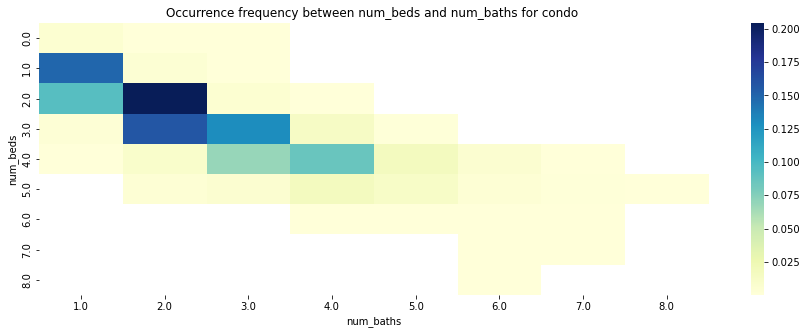

In [221]:
save_path = 'Heatmap2.png'
heatmap_y(columns, df_train.loc[df_train['property_type'] == 'condo'], (15,5), save_path=save_path)

## 1.2 data transformation

In [4]:
# Baoqi part ---- lat, lng & subzone
df_train = raw_data_train.copy()

lat_mask_global = raw_data_train['lat'] > 1.5
lng_mask_global = (raw_data_train['lng'] > 105) | (raw_data_train['lng'] < 103)
preprocess.fix_abnormal_geo_location(df_train)

preprocess.map_subzone_by_geo_location_knn(df_train)

# Lianda part ---- property_type, tenure & year
preprocess.process_property_type(df_train)
preprocess.normalize_tenure(df_train)

# handle missing value in year attribute
df_train.sort_values(by=['title', 'built_year'], inplace=True)
df_train['built_year'].fillna(method='ffill', inplace=True)

# handle missing value in planning_area attribute
df_train.sort_values(by=['subzone', 'planning_area'], inplace=True)
df_train['planning_area'].fillna(method='ffill', inplace=True)

#handle missing value in tenure attribute
df_train.loc[df_train['tenure'].isna(), 'tenure'] = 99

# Jiechen part ---- num_beds & num_baths
preprocess.process_num_beds_and_baths(df_train)

# Mingyue part ---- sqft & price
preprocess.df_process_size_sqft(df_train)
preprocess.df_process_price(df_train)

print('After handling missing values, there are now {} records.'.format(df_train.shape[0]))
print('Number of records with an NaN for any attribute: {}'.format((df_train.isna().sum(axis=1) > 0).sum()))

After handling missing values, there are now 20153 records.
Number of records with an NaN for any attribute: 17762


In [5]:
df_train.isna().any()

listing_id              False
title                   False
address                 False
property_name           False
property_type           False
tenure                  False
built_year              False
num_beds                False
num_baths               False
size_sqft               False
floor_level              True
furnishing              False
available_unit_types     True
total_num_units          True
property_details_url    False
lat                     False
lng                     False
elevation               False
subzone                 False
planning_area           False
price                   False
dtype: bool

In [6]:
# droplist = ['listing_id', 'title', 'elevation', 'floor_level', 'available_unit_types', 'total_num_units', 
#            'property_details_url']

# df_train_1 = df_train.drop(columns = droplist, inplace=True)

df_train.head()

# df_train['subzone'].value_counts()

,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,...,furnishing,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price
51,659519,4 bed condo for sale in zyanya,8 lorong 25a geylang,zyanya,condo,freehold,2025.0,4.0,3.0,1313.0,...,unspecified,"1, 2, 3, 4 br",34.0,https://www.99.co/singapore/condos-apartments/...,1.313628,103.883109,0,aljunied,geylang,2274800.0
1609,935183,4 bed condo for sale in zyanya,8 lorong 25a geylang,zyanya,condo,freehold,2025.0,4.0,3.0,1302.0,...,unspecified,"1, 2, 3, 4 br",34.0,https://www.99.co/singapore/condos-apartments/...,1.313628,103.883109,0,aljunied,geylang,2100000.0
6882,567184,4 bed condo for sale in zyanya,8 lorong 25a geylang,zyanya,condo,freehold,2025.0,4.0,3.0,1302.0,...,unspecified,"1, 2, 3, 4 br",34.0,https://www.99.co/singapore/condos-apartments/...,1.313628,103.883109,0,aljunied,geylang,2100000.0
15158,702231,4 bed condo for sale in zyanya,8 lorong 25a geylang,zyanya,condo,freehold,2025.0,4.0,3.0,1302.0,...,partial,"1, 2, 3, 4 br",34.0,https://www.99.co/singapore/condos-apartments/...,1.313628,103.883109,0,aljunied,geylang,2100000.0
9811,385898,4 bed condo for sale in zyanya,8 lorong 25a geylang,zyanya,condo,freehold,2025.0,4.0,3.0,1227.0,...,partial,"1, 2, 3, 4 br",34.0,https://www.99.co/singapore/condos-apartments/...,1.313628,103.883109,0,aljunied,geylang,2254600.0


In [95]:
def closest_mrt(df):
    matrix1 = np.array(df[['lat','lng']])
    matrix2 = np.array(mrt_station[['lat','lng']])
    dist_mrt = np.array([100.0] * matrix1.shape[0])

    for i in range(matrix1.shape[0]):
        for j in range(matrix2.shape[0]):
            dist_mrt[i] = min(dist_mrt[i], distance.distance(matrix1[i], matrix2[j]).km)
    
    df['dist_mrt'] = dist_mrt
    
    return 


def mrt_num(df):
    matrix1 = np.array(df[['lat','lng']])
    matrix2 = np.array(mrt_station[['lat','lng']])
    num_mrts = np.array([0.0] * matrix1.shape[0])

    for i in range(matrix1.shape[0]):
        for j in range(matrix2.shape[0]):
            if distance.distance(matrix1[i], matrix2[j]).km < 0.75:
                num_mrts[i] += 1
    
    df['num_mrts'] = num_mrts
    
    return

def closest_mall(df):
    matrix1 = np.array(df[['lat','lng']])
    matrix2 = np.array(mall[['lat','lng']])
    dist_mall = np.array([100.0] * matrix1.shape[0])

    for i in range(matrix1.shape[0]):
        for j in range(matrix2.shape[0]):
            dist_mall[i] = min(dist_mall[i], distance.distance(matrix1[i], matrix2[j]).km)
    
    df['dist_mall'] = dist_mall
    
    return

def conc_num(df):
    matrix1 = np.array(df[['lat','lng']])
    matrix2 = np.array(conc[['lat','lng']])
    num_malls = np.array([0.0] * matrix1.shape[0])

    for i in range(matrix1.shape[0]):
        for j in range(matrix2.shape[0]):
            if distance.distance(matrix1[i], matrix2[j]).km < 0.75:
                num_malls[i] += 1
    
    df['num_conc'] = num_malls
    
    return

def pschool_num(df):
    matrix1 = np.array(df[['lat','lng']])
    matrix2 = np.array(pschool[['lat','lng']])
    
    num_school1 = np.array([0.0] * matrix1.shape[0])
    num_school2 = np.array([0.0] * matrix1.shape[0])

    for i in range(matrix1.shape[0]):
        for j in range(matrix2.shape[0]):
            if distance.distance(matrix1[i], matrix2[j]).km < 1:
                num_school1[i] += 1
            if distance.distance(matrix1[i], matrix2[j]).km <= 2 and distance.distance(matrix1[i], matrix2[j]).km > 1:
                num_school2[i] += 1
    
    df['num_pschool1'] = num_school1
    df['num_pschool2'] = num_school2
    
    return

def mall_num(df):
    matrix1 = np.array(df[['lat','lng']])
    matrix2 = np.array(mall[['lat','lng']])
    num_malls = np.array([0.0] * matrix1.shape[0])

    for i in range(matrix1.shape[0]):
        for j in range(matrix2.shape[0]):
            if distance.distance(matrix1[i], matrix2[j]).km < 0.75:
                num_malls[i] += 1
    
    df['num_malls'] = num_malls
    
    return

In [100]:
# mrt_num(df_train)
mall_num(df_train)
pschool_num(df_train)
conc_num(df_train)

df_train.head()

NameError: name 'comc_num' is not defined

In [9]:
def encode_with_avg_price(df, attr):
    ser = df.groupby(attr)['price'].mean()
    # print(ser)
    df[attr] = df[attr].apply(lambda x: ser[x])
    #df[attr] = df.loc[:, attr].apply(lambda x: ser[x])
    
def encode_with_avg_price_sqft(df, attr):
    df['pps'] = df['price'] / df['size_sqft']
    ser = df.groupby(attr)['pps'].mean()

    # df.loc[:, attr].apply(lambda x: ser[x])
    df[attr] = df[attr].apply(lambda x: ser[x])
    df.drop('pps', axis=1, inplace=True)

In [80]:
use_list = ['built_year', 'property_type', 'tenure', 'num_beds', 'num_baths', 'furnishing', 'size_sqft', 'subzone',
            'planning_area', 'price', 'num_mrts']

df_train_s = df_train[use_list]
df_train_s['num_mrts'] = df_train_s['num_mrts']

df_train_s.head()

/var/folders/1x/nn4qj1zd2nq9j35yqwr85jgc0000gn/T/ipykernel_40829/2109736626.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_s['num_mrts'] = df_train_s['num_mrts']


,built_year,property_type,tenure,num_beds,num_baths,furnishing,size_sqft,subzone,planning_area,price,num_mrts
51,2025.0,condo,freehold,4.0,3.0,unspecified,1313.0,aljunied,geylang,2274800.0,0.0
1609,2025.0,condo,freehold,4.0,3.0,unspecified,1302.0,aljunied,geylang,2100000.0,0.0
6882,2025.0,condo,freehold,4.0,3.0,unspecified,1302.0,aljunied,geylang,2100000.0,0.0
15158,2025.0,condo,freehold,4.0,3.0,partial,1302.0,aljunied,geylang,2100000.0,0.0
9811,2025.0,condo,freehold,4.0,3.0,partial,1227.0,aljunied,geylang,2254600.0,0.0


In [81]:
encode_with_avg_price(df_train_s,'subzone')
#encode_with_avg_price_sqft(df_train_s,'property_type')

df_train_s = pd.get_dummies(df_train_s)

df_train_s.head()

/var/folders/1x/nn4qj1zd2nq9j35yqwr85jgc0000gn/T/ipykernel_40829/3645883584.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[attr] = df[attr].apply(lambda x: ser[x])
/var/folders/1x/nn4qj1zd2nq9j35yqwr85jgc0000gn/T/ipykernel_40829/3645883584.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pps'] = df['price'] / df['size_sqft']
/var/folders/1x/nn4qj1zd2nq9j35yqwr85jgc0000gn/T/ipykernel_40829/3645883584.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

,built_year,property_type,num_beds,num_baths,size_sqft,subzone,price,num_mrts,tenure_99,tenure_100,...,planning_area_sengkang,planning_area_serangoon,planning_area_singapore river,planning_area_southern islands,planning_area_tampines,planning_area_tanglin,planning_area_tengah,planning_area_toa payoh,planning_area_woodlands,planning_area_yishun
51,2025.0,2479.945487,4.0,3.0,1313.0,1231062.5,2274800.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1609,2025.0,2479.945487,4.0,3.0,1302.0,1231062.5,2100000.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
6882,2025.0,2479.945487,4.0,3.0,1302.0,1231062.5,2100000.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
15158,2025.0,2479.945487,4.0,3.0,1302.0,1231062.5,2100000.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
9811,2025.0,2479.945487,4.0,3.0,1227.0,1231062.5,2254600.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


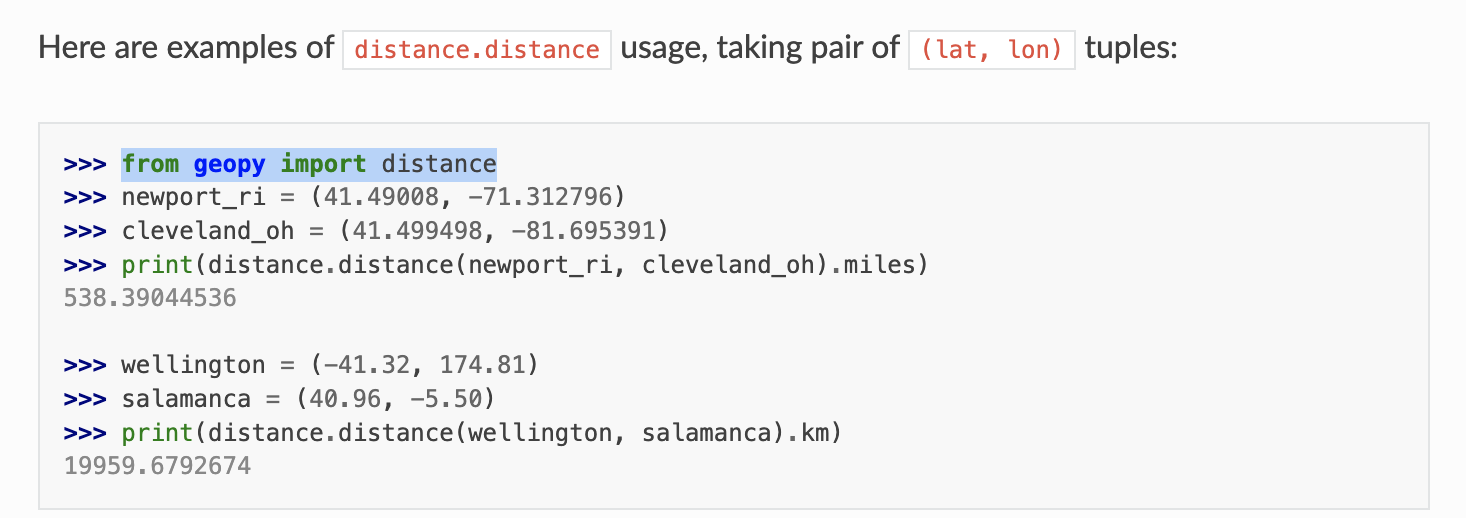

## 1.3 Feature engineering with auxiliary data

## 2 model fitting

In [82]:
def rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

def rmse_scaled(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    scale = np.sqrt(np.mean(y_true**2))
    return rmse / scale

In [83]:
np.random.seed(10)

X_train, X_test = train_test_split(df_train_s, test_size=0.1)

y_train = X_train['price']
X_train.drop('price', axis=1, inplace=True)
y_test = X_test['price']
X_test.drop('price', axis=1, inplace=True)

X_train_all = df_train_s.drop('price', axis=1)
y_train_all = df_train_s['price']

In [84]:
# create model instance
reg = XGBRegressor(gamma=1, n_estimators=500)
# fit model
reg.fit(X_train, y_train)
# make predictions
y_hat_train = reg.predict(X_train)
y_hat_test = reg.predict(X_test)

# Save model into JSON format.
#reg.save_model("regressor.json")

In [85]:
print(
    f' RMSE of Adaboost: \n {rmse(y_train, y_hat_train)} (Train) \
    \n {rmse(y_test, y_hat_test)} (Test)'
)

 RMSE of Adaboost: 
 191665.4415376685 (Train)     
 1476310.1239045279 (Test)


In [269]:
print(
    f'Scaled RMSE of Adaboost: \n {rmse_scaled(y_train, y_hat_train)} (Train) \
    \n {rmse_scaled(y_test, y_hat_test)} (Test)'
)

Scaled RMSE of Adaboost: 
 0.007044492544787372 (Train)     
 0.2658108822492448 (Test)


/Users/apple/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/apple/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Test set')

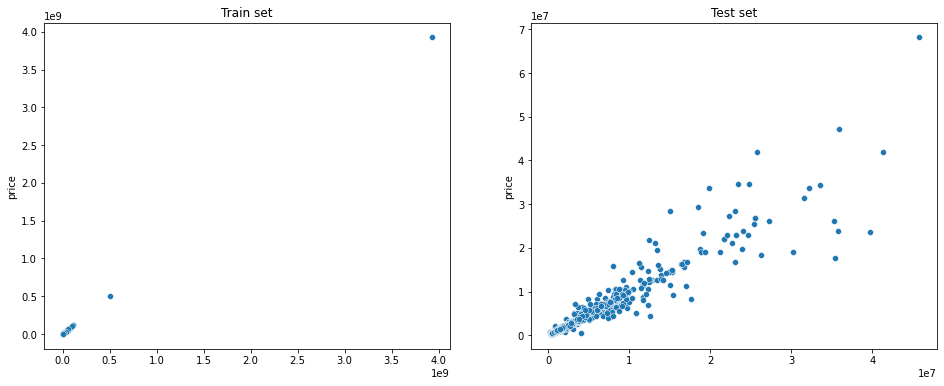

In [248]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(y_hat_train, y_train, ax=ax[0])
sns.scatterplot(y_hat_test, y_test, ax=ax[1])

ax[0].set_title('Train set')
ax[1].set_title('Test set')

## 2.1 hyper-parameters tuning
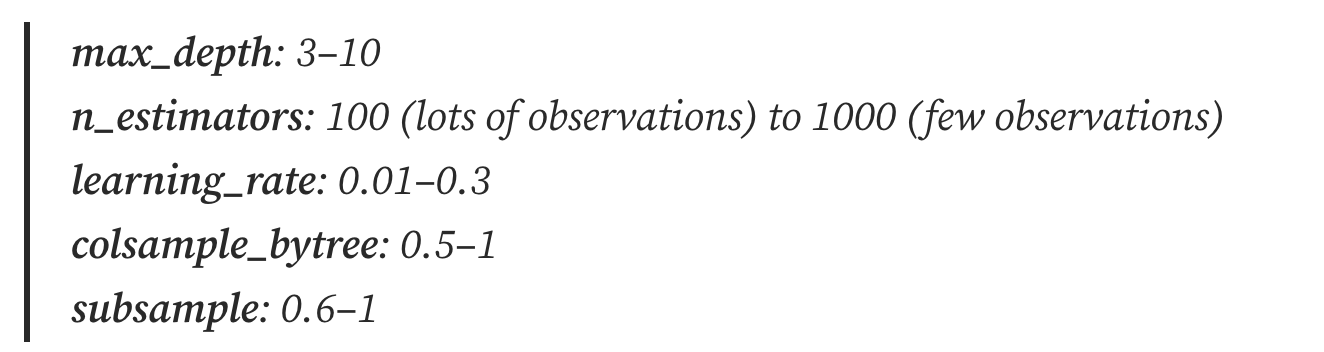

In [23]:
dmatrix = xgb.DMatrix(data=X_train_all, label=y_train_all)

params= { 'objective':'reg:squarederror',
         'max_depth': 6,
        }

cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=5, metrics={'rmse'}, as_pandas=True, seed=10, num_boost_round=50)
print('RMSE: %.2f' % cv_results['test-rmse-mean'].min())

RMSE: 13815689.08


In [16]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           #'n_estimators': [50, 100, 200],
         }

reg = XGBRegressor()

clf = GridSearchCV(estimator=reg, 
                   param_grid=params,
                   scoring='neg_root_mean_squared_error', 
                   verbose=1)
clf.fit(X_train_all, y_train_all)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 10}
Lowest RMSE:  14826169.09379897


## 2.2 model selection and visualization